In [88]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import math
from torch.autograd import Variable


In [89]:
N=60000
U = np.random.uniform(0,1,N)
X1 = np.random.multivariate_normal([0, 3*math.sqrt(3)], [[3, 0], [0, 1/3]], 60000)
X2 = np.random.multivariate_normal([0,0], [[3, 0], [0, 1/3]], 60000)
X3 = np.random.multivariate_normal([0,0], [[3, 0], [0, 1/3]], 60000)
A = [[np.cos(np.pi*2/3), -np.sin(np.pi*2/3)],[np.sin(np.pi*2/3), np.cos(np.pi*2/3)]]
B = [[np.cos(np.pi/3), -np.sin(np.pi/3)],[np.sin(np.pi/3), np.cos(np.pi/3)]]
X2 = np.matmul(A, X2.transpose()).transpose() + [-3*math.sqrt(3), -3*math.sqrt(3)/2]
X3 = np.matmul(B, X3.transpose()).transpose() + [3*math.sqrt(3), -3*math.sqrt(3)/2]

X = np.zeros((40000,2))
for i in range(40000):
    if U[i]<1/3:
        X[i] = X1[i]
    elif U[i]<2/3:
        X[i] = X2[i]
    else:
        X[i] = X3[i]
        
X_test = np.zeros((20000,2))
for i in range(40000,60000):
    if U[i]<1/3:
        X_test[i-40000] = X1[i]
    elif U[i]<2/3:
        X_test[i-40000] = X2[i]
    else:
        X_test[i-40000] = X3[i]

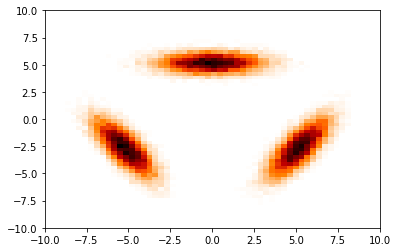

In [91]:
plt.hist2d(X[:,0],X[:,1],bins=50,cmap="gist_heat_r")
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.savefig('sigma2_gaussianmixture_2d_fullcov_z4/gm_training.png')

In [92]:
mb_size = 64
Z_dim = 4
X_dim = X.shape[1]
h_dim = 128
c = 0
lr = 1e-5

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

In [93]:
# =============================== Q(z|X) ======================================

Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Whz_mu = xavier_init(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)

Whz_var = xavier_init(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)

tri_idx_row, tri_idx_col = torch.tril_indices(row=Z_dim, col=Z_dim)
tri_idx = (tri_idx_row != tri_idx_col)  # Delete diagonal
tri_idx_row = tri_idx_row[tri_idx]
tri_idx_col = tri_idx_col[tri_idx]

Whz_L = xavier_init(size=[h_dim, len(tri_idx_col)])  # cholesky of cov
bhz_L = Variable(torch.zeros(len(tri_idx_col)), requires_grad=True)

def Q(X):
    h = nn.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    z_mu = h @ Whz_mu + bhz_mu.repeat(h.size(0), 1)
    z_logvar = h @ Whz_var + bhz_var.repeat(h.size(0), 1)
    z_L = h @ Whz_L + bhz_L.repeat(h.size(0), 1)
    return z_mu, z_logvar, z_L


# ============================ Reparameterization and Sample =============================

def sample_z(mu, log_var, L_):
    
    device = mu.device
    batch_size = mu.shape[0]
    
#     log_var = torch.clamp(log_var, max=10)
    L = torch.zeros(batch_size, Z_dim, Z_dim, device=device)
    L[:, tri_idx_row, tri_idx_col] = L_
    L += torch.diag_embed(torch.exp(log_var))  # Diagonal matrix for batch
    
    # sample noise from multivariate Gaussain
    eps = torch.randn(mu.shape[0], Z_dim, device=device)
    
    # Use batchwise matrix multiplication
    sample = mu + torch.bmm(L, eps.unsqueeze(-1)).squeeze()
    
    return eps, sample


In [94]:
# =============================== P(X|z) ======================================

Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whmu = xavier_init(size=[h_dim, X_dim])
bhmu = Variable(torch.zeros(X_dim), requires_grad=True)

Whsigma = xavier_init(size=[h_dim, X_dim])
bhsigma = Variable(torch.zeros(X_dim), requires_grad=True)

Whsigma = xavier_init(size=[h_dim, X_dim])
bhsigma = Variable(torch.zeros(X_dim), requires_grad=True)

Xtri_idx_row, Xtri_idx_col = torch.tril_indices(row=X_dim, col=X_dim)
Xtri_idx = (Xtri_idx_row != Xtri_idx_col)  # Delete diagonal
Xtri_idx_row = Xtri_idx_row[Xtri_idx]
Xtri_idx_col = Xtri_idx_col[Xtri_idx]

Whx_L = xavier_init(size=[h_dim, len(Xtri_idx_col)])  # cholesky of cov
bhx_L = Variable(torch.zeros(len(Xtri_idx_col)), requires_grad=True)

def P(z):
    h = torch.tanh(z @ Wzh + bzh.repeat(z.size(0), 1))
    X_mu = (h @ Whmu + bhmu.repeat(h.size(0), 1))
    X_log_var = (h @ Whsigma + bhsigma.repeat(h.size(0), 1))
    X_L = h @ Whx_L + bhx_L.repeat(h.size(0), 1)
    
    
    return X_mu, X_log_var, X_L

def X_full(log_var, L_):
    
    device = log_var.device
    batch_size = log_var.shape[0]
    
    L = torch.zeros(batch_size, X_dim, X_dim, device=device)
    L[:, Xtri_idx_row, Xtri_idx_col] = L_
    L += torch.diag_embed(torch.exp(log_var))  # Diagonal matrix for batch
    
    return torch.bmm(L, torch.transpose(L,1,2))

In [95]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.data = torch.flatten(self.data, start_dim=1)
        self.target = torch.from_numpy(target).float()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [96]:
dataset = MyDataset(X, X)
loader = DataLoader(
    dataset,
    batch_size=mb_size,
    shuffle=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

# for batch_idx, (data, target) in enumerate(loader):
#     print('Batch idx {}, data shape {}, target shape {}'.format(
#         batch_idx, data.shape, target.shape))


In [102]:
# =============================== TRAINING ====================================

params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var, Whz_L, bhz_L,
          Wzh, bzh, Whmu, bhmu, Whsigma, bhsigma, Whx_L, bhx_L]

solver = optim.Adam(params, lr=lr)

loss_epoch = []
x_from_prior = []
x_from_test = []

Z = torch.Tensor(np.random.multivariate_normal(np.zeros(Z_dim), np.eye(Z_dim), 2*10**4))
X_sample_mu, X_sample_logvar, X_sample_L = P(Z)
X_sample_sigma = X_full(X_sample_logvar, X_sample_L)
kernels = MultivariateNormal(X_sample_mu, X_sample_sigma)

x_from_prior.append(kernels.sample().cpu().detach().numpy())

test_data = torch.from_numpy(X_test).float()
Z_mu, Z_logvar, Z_L = Q(test_data)
_, Z = sample_z(Z_mu, Z_logvar, Z_L)
X_sample_mu, X_sample_logvar, X_sample_L = P(Z)
X_sample_sigma = X_full(X_sample_logvar, X_sample_L)
kernels = MultivariateNormal(X_sample_mu, X_sample_sigma)

x_from_test.append(kernels.sample().cpu().detach().numpy())
            
for it in range(200):
    for x_batch, y_batch in loader:
        
        # Forward
        z_mu, z_logvar, z_L = Q(x_batch)
        eps, z = sample_z(z_mu, z_logvar, z_L)
        x_sample_mu, x_sample_logvar, x_sample_L = P(z)
        x_sample_sigma = X_full(x_sample_logvar, x_sample_L)

        # Loss
        #recon_loss = nn.binary_cross_entropy(x_sample, x_batch, size_average=False) / mb_size  # Bernoulli
#         x_sample_sigma_square = torch.diag_embed(torch.exp(x_sample_logvar), dim1=-2, dim2=-1)
        kernels = MultivariateNormal(x_sample_mu, x_sample_sigma)
#         recon_loss = kernels.log_prob(x_batch[:,None,:]).mean()
        log_px_loss = -1*kernels.log_prob(x_batch).mean()
        log_qz = -torch.sum(.5*(eps**2 + math.log(2 * math.pi) + 2*z_logvar), -1)
        log_pz = -torch.sum(.5*(z**2 + math.log(2*math.pi)), -1)
        
        loss = log_px_loss - torch.mean(log_pz) + torch.mean(log_qz)

        # Backward
        loss.backward()

        # Update
        solver.step()

        # Housekeeping
        for p in params:
            if p.grad is not None:
                data = p.grad.data
                p.grad = Variable(data.new().resize_as_(data).zero_())
                

    # Print loss after each epoch
    loss_epoch.append(loss.item())
    print('Iter-{}; Loss: {:.4}'.format(it+1, loss.item()))

    # generate samples
    Z = torch.Tensor(np.random.multivariate_normal(np.zeros(Z_dim), np.eye(Z_dim), 2*10**4))
    X_sample_mu, X_sample_logvar, X_sample_L = P(Z)
    X_sample_sigma = X_full(X_sample_logvar, X_sample_L)
    kernels = MultivariateNormal(X_sample_mu, X_sample_sigma)

    x_from_prior.append(kernels.sample().cpu().detach().numpy())

    test_data = torch.from_numpy(X_test).float()
    Z_mu, Z_logvar, Z_L = Q(test_data)
    _, Z = sample_z(Z_mu, Z_logvar, Z_L)
    X_sample_mu, X_sample_logvar, X_sample_L = P(Z)
    X_sample_sigma = X_full(X_sample_logvar, X_sample_L)
    kernels = MultivariateNormal(X_sample_mu, X_sample_sigma)

    x_from_test.append(kernels.sample().cpu().detach().numpy())

Iter-201; Loss: 5.048
Iter-202; Loss: 5.012
Iter-203; Loss: 5.08
Iter-204; Loss: 5.16
Iter-205; Loss: 5.027
Iter-206; Loss: 5.072
Iter-207; Loss: 5.064
Iter-208; Loss: 4.963
Iter-209; Loss: 5.166
Iter-210; Loss: 5.007
Iter-211; Loss: 4.979
Iter-212; Loss: 5.147
Iter-213; Loss: 5.263
Iter-214; Loss: 4.946
Iter-215; Loss: 4.812
Iter-216; Loss: 4.925
Iter-217; Loss: 5.121
Iter-218; Loss: 5.177
Iter-219; Loss: 5.095
Iter-220; Loss: 5.004
Iter-221; Loss: 4.991
Iter-222; Loss: 4.922
Iter-223; Loss: 5.009
Iter-224; Loss: 5.133
Iter-225; Loss: 5.105
Iter-226; Loss: 5.013
Iter-227; Loss: 5.052
Iter-228; Loss: 5.299
Iter-229; Loss: 5.016
Iter-230; Loss: 4.844
Iter-231; Loss: 4.81
Iter-232; Loss: 5.01
Iter-233; Loss: 5.039
Iter-234; Loss: 4.933
Iter-235; Loss: 5.214
Iter-236; Loss: 4.977
Iter-237; Loss: 4.912
Iter-238; Loss: 5.05
Iter-239; Loss: 4.981
Iter-240; Loss: 4.987
Iter-241; Loss: 5.033
Iter-242; Loss: 5.012
Iter-243; Loss: 4.999
Iter-244; Loss: 4.831
Iter-245; Loss: 4.889
Iter-246; Loss:

In [104]:
np.save('sigma2_gaussianmixture_2d_fullcov_z4/fullcov_gm_loss',loss_epoch)

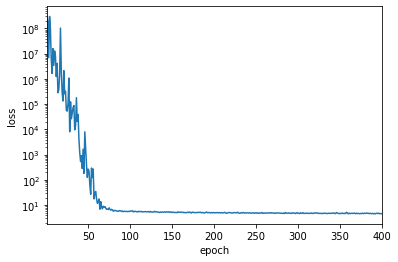

In [106]:
plt.plot(np.arange(1,401),loss_epoch)
plt.xlim(1,400)
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('sigma2_gaussianmixture_2d_fullcov_z4/gm_loss_epoch.png')

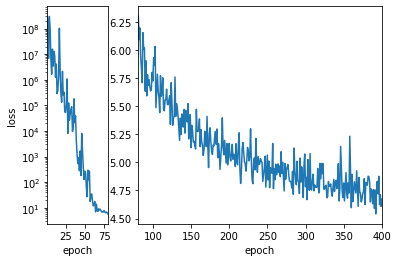

In [107]:
gs = gridspec.GridSpec(1, 2, width_ratios=[1,4])  #wspace=0.35 
ax0 = plt.subplot(gs[0])
ax0.plot(np.arange(1,81),loss_epoch[:80])
ax0.set_xlim(1,80)
ax0.set_yscale('log')
ax0.set_xlabel('epoch')
ax0.set_ylabel('loss')

ax1 = plt.subplot(gs[1])
ax1.plot(np.arange(81,401),loss_epoch[80:])
ax1.set_xlim(81,400)
ax1.set_xlabel('epoch')

plt.savefig('sigma2_gaussianmixture_2d_fullcov_z4/gm_loss_epoch_bypart.png')

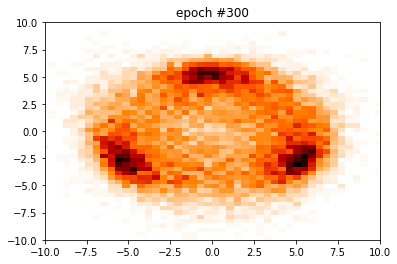

In [177]:
i += 10
plt.hist2d(x_from_prior[i][:,0],x_from_prior[i][:,1],bins=50,cmap="gist_heat_r")
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.title('epoch #'+str((i)))
plt.savefig('sigma2_gaussianmixture_2d_fullcov_z4/gm_from_prior_epoch'+str((i))+'.png')

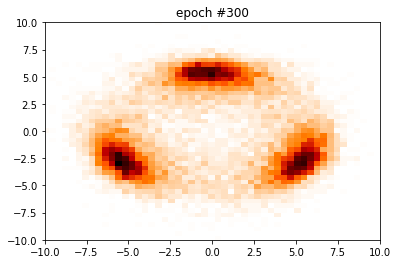

In [178]:
plt.hist2d(x_from_test[i][:,0],x_from_test[i][:,1],bins=50,cmap="gist_heat_r")
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.title('epoch #'+str((i)))
plt.savefig('sigma2_gaussianmixture_2d_fullcov_z4/gm_from_test_epoch'+str((i))+'.png')

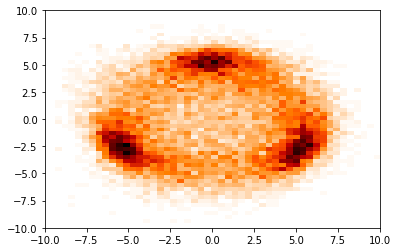

In [176]:
plt.hist2d(x_from_prior[-1][:,0],x_from_prior[-1][:,1],bins=50,cmap="gist_heat_r")
plt.xlim(-10,10)
plt.ylim(-10,10)
# plt.title('epoch #'+str((i)))
plt.savefig('sigma2_gaussianmixture_2d_fullcov_z4/gm_from_prior_final.png')

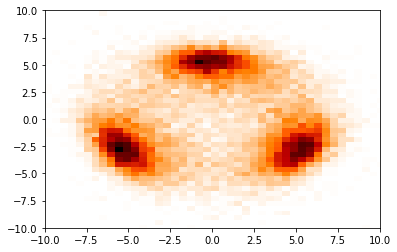

In [101]:
plt.hist2d(x_from_test[-1][:,0],x_from_test[-1][:,1],bins=50,cmap="gist_heat_r")
plt.xlim(-10,10)
plt.ylim(-10,10)
# plt.title('epoch #'+str((i)))
plt.savefig('sigma2_gaussianmixture_2d_fullcov_z4/gm_from_test_final.png')